<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/vb_gmm_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Bayes for Gaussian Mixture Models using TFP

Code is written by [Dave Moore](https://davmre.github.io/), with some tweaks by [Kevin Murphy](https://www.cs.ubc.ca/~murphyk/).

We use a diagonal Gaussian approximation to the posterior (after transforming the variables) using  SVI objective, optimized with full batch gradient descent. See [here](https://github.com/probml/pyprobml/blob/master/scripts/variational_mixture_gaussians_demo.py) for code that implements full-batch VBEM using a conjugate prior.


In [67]:
import functools
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
#from matplotlib import pylab as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__, tfp.__version__)

2.5.0 0.13.0


# Plotting code

In [68]:


from matplotlib.patches import Ellipse

def plot_loc_scale(weight_, loc_, scale_tril_, color, ax):
  cov = np.dot(scale_tril_, scale_tril_.T)
  w, v = np.linalg.eig(cov)
  angle = np.arctan2(v[1, 0], v[1, 1]) * 360 / (2*np.pi)
  height = 3 * np.sqrt(w[1])  # minor axis
  width = 3 * np.sqrt(w[0])  # major axis

  e = Ellipse(xy=loc_,
              width=width,
              height=height,
              angle=angle)
  ax.add_artist(e)
  e.set_clip_box(ax.bbox)
  e.set_alpha(weight_)
  e.set_facecolor(color)
  e.set_edgecolor("black")

def plot_posterior_with_data(mix_, loc_, scale_tril_, data, ax, facecolors=None):
  ax.plot(data[:, 0], data[:, 1], 'k.', markersize=3);
  ax.plot(loc_[:, 0], loc_[:, 1], 'r^');

  num_components = len(mix_)
  np.random.seed(420)
  if facecolors is None:
    facecolors = sns.color_palette('deep', n_colors=num_components)

  weights_ = np.sqrt(mix_)
  weights_ = weights_ * (0.5 / np.max(weights_))
  for i, (weight_, l_, st_) in enumerate(zip(weights_, loc_, scale_tril_)):
    plot_loc_scale(weight_, l_, st_, color=facecolors[i], ax=ax)

def plot_posterior_sample(surrogate_posterior, data):
  fig = plt.figure(figsize=(10, 6), constrained_layout=True)
  gs = fig.add_gridspec(4, 4)
  mix, loc, _, _, scale_tril = surrogate_posterior.sample()
  num_components = len(mix)
  plot_posterior_with_data(mix.numpy(),
                          loc.numpy(),
                          scale_tril.numpy(),
                          data=data,
                          ax=fig.add_subplot(gs[:, :3]))

  ax = fig.add_subplot(gs[:1, 3])
  sns.barplot(x=np.arange(num_components), y=mix.numpy(), ax=ax, palette='deep')
  ax.set_title('Mixture component weights')

# Data

We use a datset of erruption times from the "Old Faithful" geyser in Yellowstone National Park. 

In [69]:
url = 'https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt'
#df = pd.read_csv(url, sep='\t', header=None, columns=['eruptions', 'waiting'])
!wget $url
data = np.array(np.loadtxt("faithful.txt"))
print(data.shape)

--2021-07-14 20:06:38--  https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5167 (5.0K) [text/plain]
Saving to: ‘faithful.txt.2’

faithful.txt.2      100%[===================>]   5.05K  --.-KB/s    in 0s      

2021-07-14 20:06:38 (67.9 MB/s) - ‘faithful.txt.2’ saved [5167/5167]

(272, 2)


Text(0, 0.5, 'Waiting time (mins)')

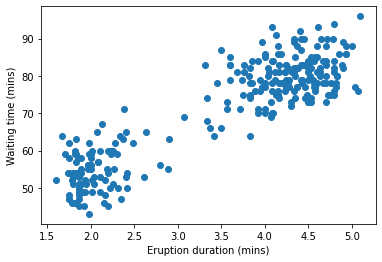

In [70]:
plt.figure()
plt.scatter(data[:,0], data[:,1])
plt.xlabel('Eruption duration (mins)')
plt.ylabel('Waiting time (mins)')

In [71]:
# Standardize the data (to simplify model fitting)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data_normalized = (data - mean) / std

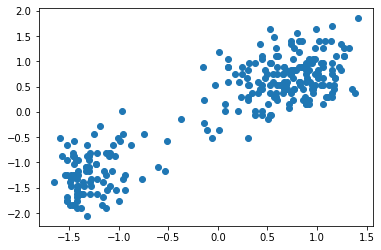

In [72]:
plt.figure()
plt.scatter(data_normalized[:,0], data_normalized[:,1])


# Model

We put a Gaussian prior on each mean vector, an LKJ prior on each correlation matrix, and a half-normal prior on each scale vector. (This is not a conjugate prior.) 

In [73]:
def bayesian_gaussian_mixture_model(num_observations, dims, components):
  mixture_probs = yield tfd.Dirichlet(
      concentration=tf.ones(components, dtype=tf.float32) / components,
      name='mixture_probs')
  loc = yield tfd.Normal(loc=tf.zeros([components, dims]),
                         scale=1,
                         name='loc')
  
  scale = yield tfd.HalfNormal(scale=2 * tf.ones([components, dims]),
                               name='scale')
  correlation_tril = yield tfd.CholeskyLKJ(
      dimension=dims,
      concentration=tf.ones([components]),
      name='correlation_tril')
  scale_tril = yield tfd.Deterministic(
      scale[..., tf.newaxis] * correlation_tril,
      name='scale_tril')

  observations = yield tfd.Sample(
      tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=mixture_probs),
        components_distribution=tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale_tril)),
      sample_shape=num_observations,
      name='observations')
  


  


In [74]:
ncomponents = 10
ndata = data.shape[0]
ndims = data.shape[1]

bgmm = tfd.JointDistributionCoroutineAutoBatched(
    functools.partial(bayesian_gaussian_mixture_model,
                      dims=ndims,
                      components=ncomponents,
                      num_observations=ndata))

In [98]:
x = bgmm.sample() 
print(type(x))

<class 'tensorflow_probability.python.internal.structural_tuple.structtuple.<locals>.StructTuple'>


In [75]:
# Sample from the prior predictive joint distribution
x = bgmm.sample() 
print(type(x))
#print(x)
print(x.mixture_probs.shape)
print(x.mixture_probs)
print(x.loc.shape)
print(x.scale.shape)
print(x.correlation_tril.shape)
print(x.scale_tril.shape)
print(x.observations.shape)
print('sample data')
print(x.observations[:5,:])

<class 'tensorflow_probability.python.internal.structural_tuple.structtuple.<locals>.StructTuple'>
(10,)
tf.Tensor(
[1.2697814e-04 2.6216380e-06 1.5227304e-01 5.7231462e-01 4.7871076e-06
 3.0676740e-05 2.9291652e-02 5.2601496e-05 2.3652741e-01 9.3756793e-03], shape=(10,), dtype=float32)
(10, 2)
(10, 2)
(10, 2, 2)
(10, 2, 2)
(272, 2)
sample data
tf.Tensor(
[[ 1.1562599   0.4112712 ]
 [ 1.7899197  -1.4059222 ]
 [ 0.44063005 -0.6896139 ]
 [-0.5392513   7.8784485 ]
 [ 0.19295786 -0.3424785 ]], shape=(5, 2), dtype=float32)


In [76]:
print(bgmm.log_prob(x))

tf.Tensor(-1111.151, shape=(), dtype=float32)


In [77]:
# Clamp the observations
pinned = bgmm.experimental_pin(observations=data_normalized)

In [100]:
print(type(pinned))
print(pinned)

<class 'tensorflow_probability.python.experimental.distributions.joint_distribution_pinned.JointDistributionPinned'>
tfp.distributions.JointDistributionPinned("PinnedJointDistributionCoroutineAutoBatched", batch_shape=[], event_shape=StructTuple(
  mixture_probs=[10],
  loc=[10, 2],
  scale=[10, 2],
  correlation_tril=[10, 2, 2],
  scale_tril=[10, 2, 2]
), dtype=StructTuple(
  mixture_probs=float32,
  loc=float32,
  scale=float32,
  correlation_tril=float32,
  scale_tril=float32
))


In [101]:
# Sample from the clamped model - this needs a posterior inference engine!
if False:
  x = pinned.sample() 
  print('sample')
  print(x.observations[:5,:])
  print('data')
  print(data_normalized[:5,:])


# Fitting a point mass posterior (MAP estimate)

This marginalizes over the discrete latent indicators (as part of MixtureSameFamily logprob computation), but uses point estimates for model parameters, similar to standard EM. Thus there is no "Bayes Occam's razor" penalty factor when choosing too many mixture components.

In [79]:
def trainable_point_estimate(initial_loc, initial_scale, event_ndims, validate_args):
  return tfd.Independent(
      tfd.Deterministic(tf.Variable(initial_loc), validate_args=validate_args),
      reinterpreted_batch_ndims=event_ndims)

point_mass_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    pinned.event_shape,
    bijector=pinned.experimental_default_event_space_bijector(),
    trainable_distribution_fn=trainable_point_estimate)

In [80]:
import time
t0 = time.time()
num_steps = 1000
losses = tfp.vi.fit_surrogate_posterior(
    pinned.unnormalized_log_prob,
    point_mass_posterior,
    optimizer=tf.optimizers.Adam(3e-2),
    num_steps=int(num_steps))
t1 = time.time()
print("{} variational steps finished in {:.3f}s".format(num_steps, t1-t0))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use state

1000 variational steps finished in 4.806s


Text(0.5, 1.0, 'Training loss curve')

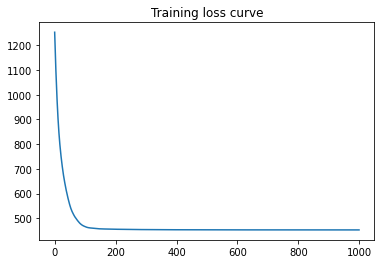

In [81]:
# The negative log data likelihood goes down monotonically, as EM theory predicts
plt.plot(losses)
plt.title("Training loss curve")

In [82]:
print(point_mass_posterior)


tfp.distributions.TransformedDistribution("build_factored_surrogate_posterior_default_joint_bijectorbuild_factored_surrogate_posterior_JointDistributionNamed", batch_shape=StructTuple(
  mixture_probs=[],
  loc=[],
  scale=[],
  correlation_tril=[],
  scale_tril=[]
), event_shape=StructTuple(
  mixture_probs=[10],
  loc=[10, 2],
  scale=[10, 2],
  correlation_tril=[10, 2, 2],
  scale_tril=[10, 2, 2]
), dtype=StructTuple(
  mixture_probs=float32,
  loc=float32,
  scale=float32,
  correlation_tril=float32,
  scale_tril=float32
))


Samples from the posterior predictive distribution should be constant across sampling runs, since we use a point estimate of the parameters.

In [96]:
params = point_mass_posterior.sample()
print(params.mixture_probs)

tf.Tensor(
[0.0405486  0.00070947 0.42902428 0.17929807 0.00063791 0.13472322
 0.04182411 0.00067089 0.05444786 0.11811556], shape=(10,), dtype=float32)


In [97]:
params = point_mass_posterior.sample()
print(params.mixture_probs)

tf.Tensor(
[0.0405486  0.00070947 0.42902428 0.17929807 0.00063791 0.13472322
 0.04182411 0.00067089 0.05444786 0.11811556], shape=(10,), dtype=float32)


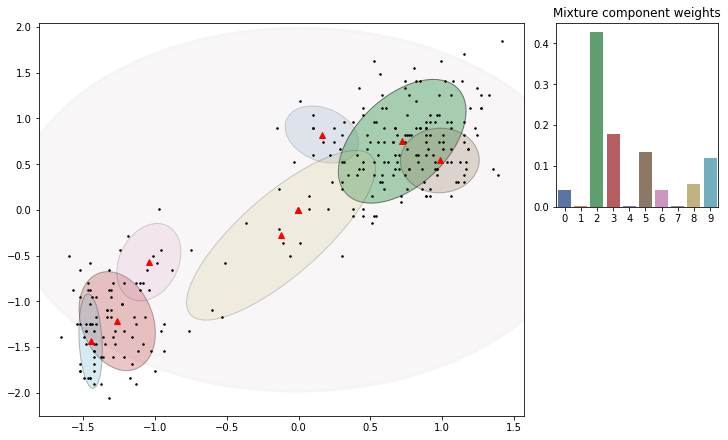

In [85]:
plot_posterior_sample(point_mass_posterior, data=data_normalized)
plt.savefig('vb_gmm_map_sample.pdf')
plt.show()

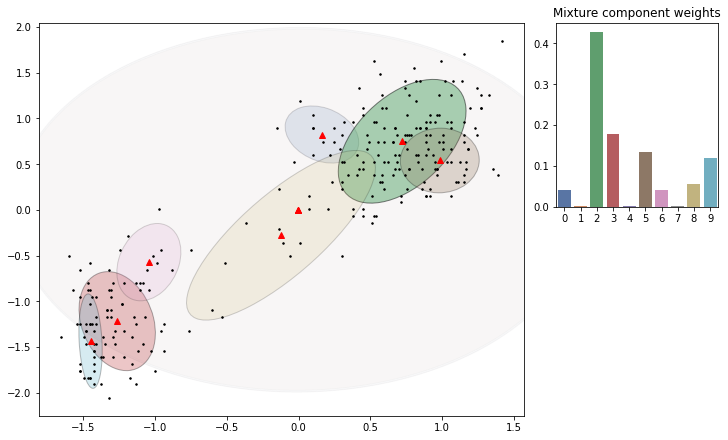

In [86]:
plot_posterior_sample(point_mass_posterior, data=data_normalized)

# Fitting a diagonal Gaussian posterior

Construct and fit a surrogate posterior using stochastic gradient VI. The surrogate is a diagonal Gaussian that is transformed into the support of the model's parameters using appropriate bijectors.

In [87]:
surrogate_posterior = tfp.experimental.vi.build_affine_surrogate_posterior(
    pinned.event_shape,
    bijector=pinned.experimental_default_event_space_bijector(),
    operators='diag')

In [88]:
import time
t0 = time.time()
num_steps = 1000
losses = tfp.vi.fit_surrogate_posterior(
    pinned.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=tf.optimizers.Adam(2e-2),
    num_steps=int(num_steps))
t1 = time.time()
print("{} variational steps finished in {:.3f}s".format(num_steps, t1-t0))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use state

1000 variational steps finished in 7.253s


Text(0.5, 1.0, 'Training loss curve')

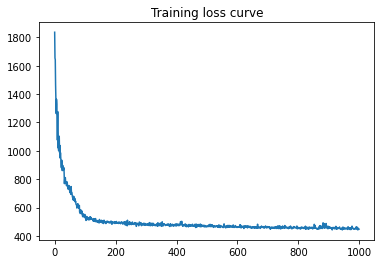

In [89]:
plt.plot(losses)
plt.title("Training loss curve")

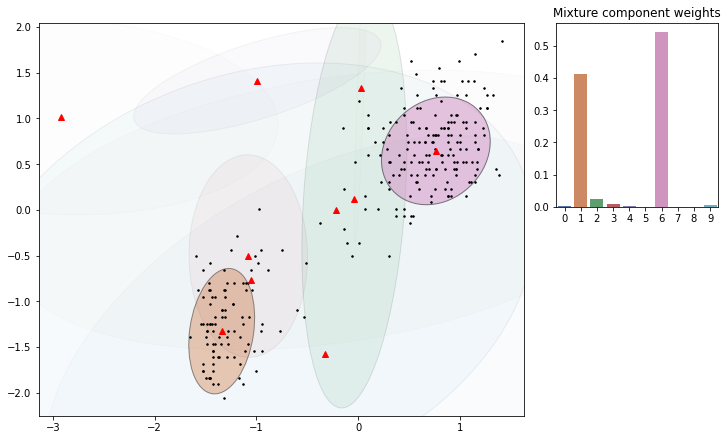

In [90]:
plot_posterior_sample(surrogate_posterior, data=data_normalized)
plt.savefig('vb_gmm_bayes_sample1.pdf')
plt.show()

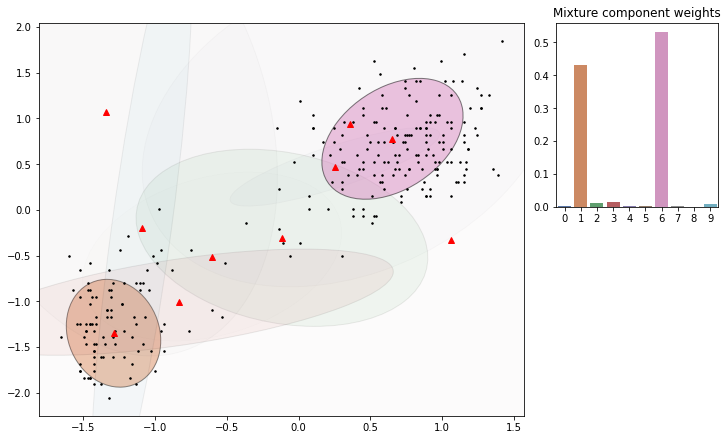

In [91]:
plot_posterior_sample(surrogate_posterior, data=data_normalized)
plt.savefig('vb_gmm_bayes_sample2.pdf')
plt.show()

In [93]:
params = surrogate_posterior.sample()
print(params.mixture_probs)

tf.Tensor(
[2.23936467e-03 3.64494860e-01 5.86357564e-02 1.12465797e-02
 9.28402471e-04 6.39106001e-05 5.53885102e-01 6.51227252e-04
 1.21413046e-04 7.73340464e-03], shape=(10,), dtype=float32)


In [94]:
params = surrogate_posterior.sample()
print(params.mixture_probs)

tf.Tensor(
[1.3826601e-03 4.2224973e-01 1.6281165e-02 6.7551960e-03 1.8640651e-03
 3.2661634e-04 5.4102653e-01 1.4823949e-03 2.0768255e-04 8.4240157e-03], shape=(10,), dtype=float32)
